In [1]:
import os
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')

In [2]:
from PythonFiles.model import model,preprocessing,data_split,highlight_entry,create_transformation,plot_prob_forecasts,make_one_ts_prediction
from PythonFiles.Configuration import Configuration
from gluonts.dataset import common
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
import numpy as np
from gluonts.evaluation import make_evaluation_predictions
import gluonts
from datetime import datetime
config=Configuration()
df=pd.read_csv("Influenza.csv",sep=',')
df.head()

,Unnamed: 0,year,date,week,age_group,location,value
0,0,2002,2002-01-06,1,00+,LK Alb-Donau-Kreis,0.0
1,1,2002,2002-01-13,2,00+,LK Alb-Donau-Kreis,0.0
2,2,2002,2002-01-20,3,00+,LK Alb-Donau-Kreis,0.0
3,3,2002,2002-01-27,4,00+,LK Alb-Donau-Kreis,0.0
4,4,2002,2002-02-03,5,00+,LK Alb-Donau-Kreis,0.0


## Only looking at one Time Series (i.e. only one location)

In [3]:
one_ts_df=df.loc[df.location=="LK Bad Dürkheim",["value",'location','date']]
one_ts_df=preprocessing(config,one_ts_df,check_count=False,output_type="corrected_df")
one_ts_df

,value,location
2010-01-03,1.0,LK Bad Dürkheim
2010-01-10,1.0,LK Bad Dürkheim
2010-01-17,0.0,LK Bad Dürkheim
2010-01-24,0.0,LK Bad Dürkheim
2010-01-31,0.0,LK Bad Dürkheim
...,...,...
2019-12-01,0.0,LK Bad Dürkheim
2019-12-08,1.0,LK Bad Dürkheim
2019-12-15,1.0,LK Bad Dürkheim
2019-12-22,1.0,LK Bad Dürkheim


In [4]:
train_set=one_ts_df.loc[(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_start_time),:]
test_set=one_ts_df.loc[(one_ts_df.index>=config.train_start_time) &(one_ts_df.index<=config.test_end_time),:]
window_dates=[]
for window in range(1,config.windows+1):
    unique_weeks=test_set.index.unique()
    selected_split_week=unique_weeks[-window*config.prediction_length:-window*config.prediction_length +1]
    window_dates.append(datetime(selected_split_week.year[0],selected_split_week.month[0],selected_split_week.day[0]))
    
test_windows=[test_set.loc[test_set.index<window_date,:] for window_date in window_dates]
#train_set=PandasDataset(train_set,freq=config.freq)
train_set=PandasDataset.from_long_dataframe(dataframe=train_set,item_id='location', target="value",freq="W-SUN")
test_set=PandasDataset(test_windows, target="value",freq=config.freq)
#test_set1=PandasDataset.from_long_dataframe(dataframe=test_windows[0],item_id='location', target="value",freq="W-SUN")
#test_set2=PandasDataset.from_long_dataframe(dataframe=test_windows[2],item_id='location', target="value",freq="W-SUN")
#test_set=PandasDataset(test_set1,test_set1,freq=config.freq)
print(test_set)

PandasDataset(dataframes=[            value         location
2010-01-03    1.0  LK Bad Dürkheim
2010-01-10    1.0  LK Bad Dürkheim
2010-01-17    0.0  LK Bad Dürkheim
2010-01-24    0.0  LK Bad Dürkheim
2010-01-31    0.0  LK Bad Dürkheim
...           ...              ...
2018-12-02    0.0  LK Bad Dürkheim
2018-12-09    0.0  LK Bad Dürkheim
2018-12-16    0.0  LK Bad Dürkheim
2018-12-23    0.0  LK Bad Dürkheim
2018-12-30    0.0  LK Bad Dürkheim

[470 rows x 2 columns],             value         location
2010-01-03    1.0  LK Bad Dürkheim
2010-01-10    1.0  LK Bad Dürkheim
2010-01-17    0.0  LK Bad Dürkheim
2010-01-24    0.0  LK Bad Dürkheim
2010-01-31    0.0  LK Bad Dürkheim
...           ...              ...
2017-12-03    0.0  LK Bad Dürkheim
2017-12-10    0.0  LK Bad Dürkheim
2017-12-17    0.0  LK Bad Dürkheim
2017-12-24    1.0  LK Bad Dürkheim
2017-12-31    1.0  LK Bad Dürkheim

[418 rows x 2 columns]], target='value', timestamp=None, freq='W-SUN', feat_dynamic_real=[], feat_dynamic_ca

In [5]:
forecasts,tss=model(config,train_set,test_set)

100%|██████████| 50/50 [00:06<00:00,  8.11it/s, epoch=4/4, avg_epoch_loss=1]


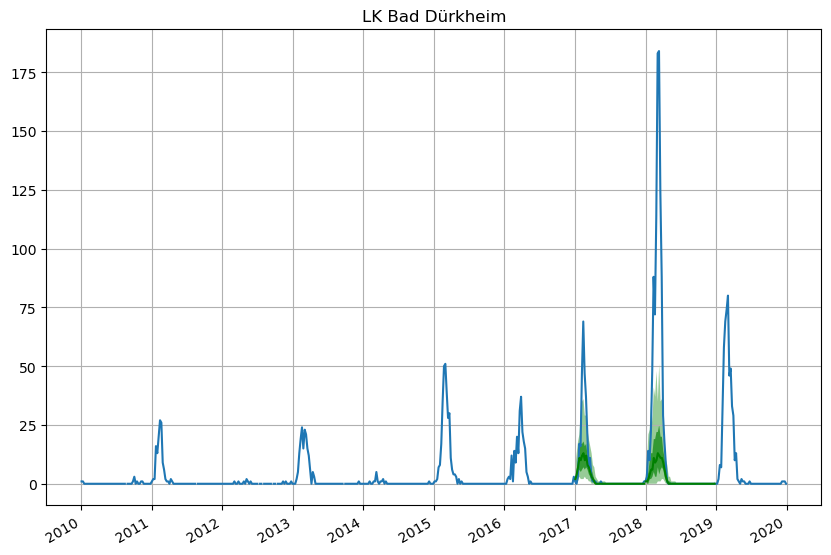

In [6]:
locations=[x for x in one_ts_df.loc[:,'location'].unique()]
start=one_ts_df.loc[(one_ts_df.index>=config.train_start_time)].index[0]
test_data= common.ListDataset(
    [{"start": start,"target": one_ts_df.loc[(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_start_time)& (one_ts_df.location == x),config.target]} for x in one_ts_df.loc[: ,'location'].unique()],freq=config.freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.title(f'{locations[0]}')
plt.plot((one_ts_df.loc[(one_ts_df['location']==str(locations[0]))&(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_start_time)].index),
         one_ts_df.loc[(one_ts_df['location']==str(locations[0]))&(one_ts_df.index<=config.test_end_time) &(one_ts_df.index>=config.train_start_time),'value'])
plt.grid(which="both")
color=["g","r"]
for k in [0,1]:
    ts_entry=tss[k]
    forecast_entry=forecasts[k]
    prediction_intervals = (50.0, 90.0)
    legend = ['train_set observations',"median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]
    forecast_entry.plot(prediction_intervals=prediction_intervals, color=color)
    plt.grid(which="both")
plt.show()

In [7]:
print(forecasts[1])
print(2)
print(forecasts[0])

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=numpy.array([[2.0, 6.0, 2.0, 10.0, 5.0, 11.0, 7.0, 7.0, 7.0, 2.0, 15.0, 6.0, 10.0, 2.0, 5.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.0, 5.0, 1.0, 7.0, 8.0, 6.0, 5.0, 9.0, 12.0, 10.0, 11.0, 12.0, 8.0, 4.0, 7.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [8.0, 2.0, 11.0, 4.0, 9.0, 19.0, 16.0, 4.0, 34.0, 15.0, 13.0, 6.0, 7.0, 3.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 1.0, 2.0, 5.0, 5.0, 1.0, 7.0, 10.0, 13.0, 12.0, 18.0, 20.0, 15.0, 15.0, 2.0, 3.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0

## Turned the previous process into a function

[datetime.datetime(2018, 7, 8, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 12, 31, 23, 0)]


100%|██████████| 50/50 [00:10<00:00,  4.93it/s, epoch=4/4, avg_epoch_loss=0.739]


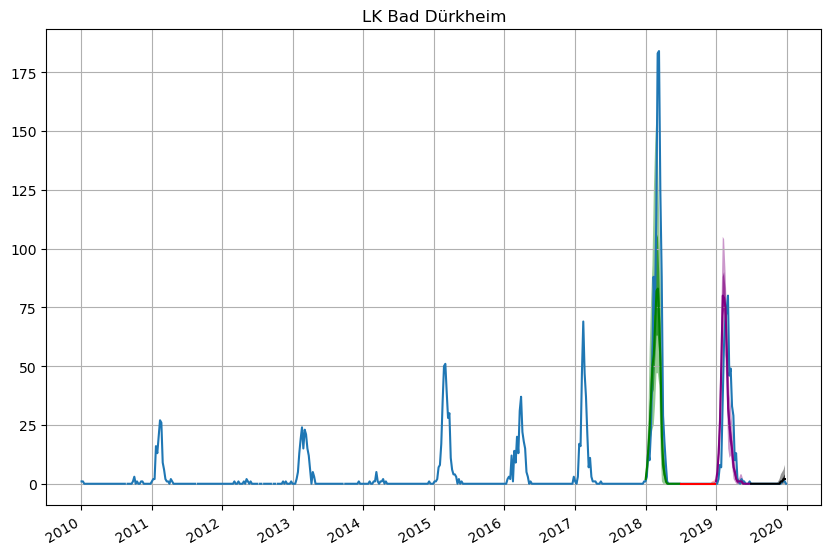

[datetime.datetime(2018, 7, 8, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 12, 31, 23, 0)]


In [3]:
forecasts,tss=make_one_ts_prediction(config,df,location="LK Bad Dürkheim")

[datetime.datetime(2018, 7, 8, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 12, 31, 23, 0)]


100%|██████████| 50/50 [00:11<00:00,  4.52it/s, epoch=4/4, avg_epoch_loss=0.872]


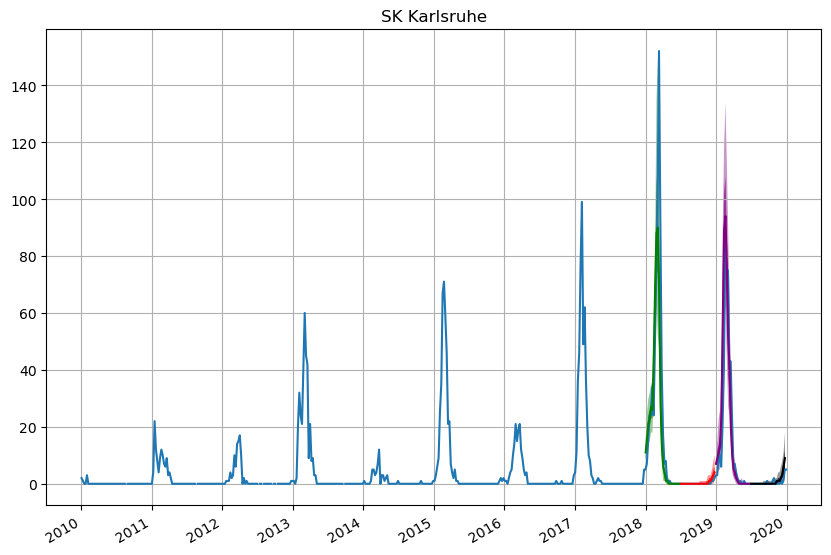

[datetime.datetime(2018, 7, 8, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 12, 31, 23, 0)]


In [4]:
forecasts,tss=make_one_ts_prediction(config,df,location="SK Karlsruhe")

In [ ]:
forecasts,tss=make_one_ts_prediction(config,df,location="SK Speyer")

[datetime.datetime(2018, 7, 8, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2019, 7, 7, 0, 0), datetime.datetime(2019, 12, 31, 23, 0)]


  0%|          | 0/50 [00:00<?, ?it/s]